# scikit-learn

## Overview

Scikit-learn [R] is a Python package containing a wide selection of tools for machine learning. Machine learning is a technique of using computers to make predtictions on unseen data based on either previously seen data or algorithms which find patterns within data. In addition to a large collection of data analysis algorithms, the package also provides tools for data preprocessing and dimensionality reduction; model selection and hyperparameter tuning - that is, finding an algorithm and a set of parameters to that algorithm that enable it to best perform on a particular dataset.


## Imports

The following code cells import all the libraries necessary to run this notebook. As there are a lot of imports, they are divided into four cells according to their function for easier management. 

In [1]:
# General utilities

# file management
import os
# downloading datasets
import requests
# url construction
from urllib.parse import urljoin

In [2]:
# Plotting libraries

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

In [184]:
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.base import TransformerMixin
from sklearn.cluster import FeatureAgglomeration

## The Wine Quality Dataset
The wine quality dataset, available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/), consists of two semicolon-delimited files, one relating to Portuguese *Vinho Verde* red wines and one to whites. The datasets were produced by [Cortez et al.][cortezetal] in order to assess various machine learning algorithms in prediction of the quality of a wine from its properties. They considered support vector machines (SVM), multiple regression analysis, and neural networks. Of these the best performance was achieved using SVM [RPaper,RDatasheet].

Twelve attributes are recorded for each wine sample; eleven are objective physical or chemical attributes, and one, `quality`, is a subjective assessment of the wine's quality. The `quality` attribute is recorded as a value from 0 (poorest quality) to 10 (best quality) and is derived from the median score assigned to it by at least three experts [RDatasheet].

The data information sheet distributed with the data [R] notes that several attributes may be correlated and that not all attributes necessarily affect quality and suggests that feature selection may be advisable. The datasheet also suggests that the problem of wine quality prediction may be cast as a regression problem or as a classification problem.

### Procedure

1. [Acquire the data](#Acquire-the-dataset)
1. [Split the data](#Split-the-data)
1. [Explore the data](#Explore-the-dataset)
    1. [View a sample of each dataset](#View-the-data)
    1. [View the distribution of each feature](#View-the-distribution-of-each-feature)
    1. [View distribution of target variable](#View-distribution-of-target-variable)
    1. [View correlations between features](#View-feature-correlations)
    1. [Assess relative influence of each feature on the target variable](#Assess-relative-influence-of-each-feature-on-the-target-variable)
1. [Feature scaling](#Feature-scaling)
    1. Consider whether any or all of the features should be normalised or standardised in some way
    1. Generate adjusted subsets for each of the subsets generated above
1. [Dimensionality reduction](#Dimensionality-reduction)
    1. [Feature selection](#Feature-selection)
    1. [Principal Components Analysis](#Principal-components-analysis) 
1. Model selection
    1. Decide on whether the problem will be cast as binary classification, multiclass classification, or regression
    1. Adjust target variable as necessary
    1. Select some suitable models
1. Hyperparameter tuning
    1. Construct a grid search or randomized search to test various combinations of hyperparameters
1. Fit and assess models
    1. Fit each model/hyperparameter/featureset combination
    1. Conduct assessment appropriate to each combination
    1. Select best candidates and fine tune
1. Test predictions
    1. Use trained model(s) to predict test set
    2. Assess model performance on test set


### Acquire the dataset
The dataset is downloaded as two semicolon delimited files from the UCI Machine Learning Repository and saved to disc. 

In [5]:
# Location of wine quality dataset
base_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/'
# Local data directory
data_dir = 'data/wine/'

# Names of dataset files to be downloaded
source_files = ('winequality-red.csv', 'winequality-white.csv', 'winequality.names')

# for each of the source files construct url, 
# fetch file, and write to data directory
for datafile in (source_files):
    response = requests.get(urljoin(base_url, datafile))
    with open(os.path.join(data_dir, datafile), 'wb') as f:
        f.write(response.content)

The data is then loaded into two pandas dataframes, one for the red wine dataset and one for the white.

In [53]:
# Load red wine and white wine datasets into pandas DataFrames
redwine = pd.read_csv('data/wine/winequality-red.csv', delimiter=";")
whitewine = pd.read_csv('data/wine/winequality-white.csv', delimiter=";")

## Split the data
Each of the two wine datasets is split into a training set, representing 80% of the data, and a test set, representing the other 20%. The data is shuffled before splitting and the split is stratified on the `quality` output variable. This ensures that each category is proportionally represented in both the training and test sets. It is necessary to do this because, as noted [below](#View-distribution-of-target-variable), the target variable is unevenly distributed. The input features are also split from the target variable in both the training and testing sets. The input feature DataFrame names are prefixed with an `X` and the targets with a `y`. The split is conducted using `sklearn.model_selection.train_test_split()` [5].

In [54]:
# Split red wine data into random training and test (20%) subsets with stratified sampling on quality
X_train_rw, X_test_rw, y_train_rw, y_test_rw = \
    train_test_split(redwine.drop('quality', axis=1), redwine['quality'], stratify=redwine['quality'], test_size=0.2)
# Split red wine data into random training and test (20%) subsets with stratified sampling on quality
X_train_ww, X_test_ww, y_train_ww, y_test_ww = \
    train_test_split(whitewine.drop('quality', axis=1), whitewine['quality'], stratify=whitewine['quality'], test_size=0.2)

## Explore the dataset
Two DataFrames are created, `rw` and `ww`, representing The red wine and white wine datasets respectively. They are subset from the original full datasets as loaded from csv using the training set indices. They will be used to explore the data. The instances in the test subsets must remain unseen if the analysis is to remain unbiased by their contents.

In [65]:
rw = redwine.iloc[X_train_rw.index]
ww = whitewine.iloc[X_train_ww.index]
# Give the DataFrames name attributes for quick labelling of output
rw.name, ww.name = "Red Wine", "White Wine"

### View the data
The first five rows of each of the two DataFrames are viewed using `pandas.DataFrame.head()`. This gives a general idea of the structure of the dataset.

In [67]:
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    display(w.head())

-----------
Red Wine
-----------


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1090           10.0             0.260         0.54             1.9      0.083   
187             7.7             0.705         0.10             2.6      0.084   
1237            7.1             0.750         0.01             2.2      0.059   
1483            8.1             0.330         0.44             1.5      0.042   
1524            6.0             0.420         0.19             2.0      0.075   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
1090                 42.0                  74.0  0.99451  2.98       0.63   
187                   9.0                  26.0  0.99760  3.39       0.49   
1237                 11.0                  18.0  0.99242  3.39       0.40   
1483                  6.0                  12.0  0.99542  3.35       0.61   
1524                 22.0                  47.0  0.99522  3.39       0.78   

      alcohol  quality  
1090     11.8        8  
187       9.7        5  
1237     12.8        6  
1483     10.7        5  
1524     10.0        6

-----------
White Wine
-----------


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1425            6.8              0.22         0.49             0.9      0.052   
4856            7.1              0.23         0.39            13.7      0.058   
3012            6.8              0.25         0.37             3.1      0.026   
3678            7.2              0.23         0.25            18.8      0.085   
2664            6.2              0.21         0.34             6.6      0.030   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
1425                 26.0                 128.0  0.99100  3.25       0.35   
4856                 26.0                 172.0  0.99755  2.90       0.46   
3012                 29.0                  93.0  0.99035  3.14       0.45   
3678                 19.0                 111.0  1.00044  3.10       0.51   
2664                 36.0                  91.0  0.99140  3.32       0.45   

      alcohol  quality  
1425     11.4        6  
4856      9.0        6  
3012     12.2        6  
3678      8.7        5  
2664     12.5        7

***

The `DataFrame.info()` function returns the name, count, and datatype of each feature in the DataFrame. Each of the two wine datasets consists of 11 input variables of type `float64` and one out put variable of type `int64`. The red wine data contains 1599 samples and the white wine data contains 4898. Neither has any missing values.

In [68]:
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    print(w.info())

-----------
Red Wine
-----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1279 entries, 1090 to 1332
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1279 non-null   float64
 1   volatile acidity      1279 non-null   float64
 2   citric acid           1279 non-null   float64
 3   residual sugar        1279 non-null   float64
 4   chlorides             1279 non-null   float64
 5   free sulfur dioxide   1279 non-null   float64
 6   total sulfur dioxide  1279 non-null   float64
 7   density               1279 non-null   float64
 8   pH                    1279 non-null   float64
 9   sulphates             1279 non-null   float64
 10  alcohol               1279 non-null   float64
 11  quality               1279 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 129.9 KB
None
-----------
White Wine
-----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 

***

The `DataFrame.describe()` function returns a table containing descriptive statistics for each of the features.

In [69]:
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    display(w.describe().round(2))

-----------
Red Wine
-----------


fixed acidity  volatile acidity  citric acid  residual sugar  \
count        1279.00           1279.00      1279.00         1279.00   
mean            8.37              0.53         0.28            2.54   
std             1.79              0.18         0.20            1.42   
min             4.60              0.12         0.00            0.90   
25%             7.10              0.39         0.10            1.90   
50%             7.90              0.52         0.26            2.20   
75%             9.30              0.64         0.44            2.60   
max            15.90              1.58         1.00           15.50   

       chlorides  free sulfur dioxide  total sulfur dioxide  density       pH  \
count    1279.00              1279.00               1279.00  1279.00  1279.00   
mean        0.09                15.61                 46.10     1.00     3.31   
std         0.05                10.12                 32.82     0.00     0.16   
min         0.01                 1.00                  6.00     0.99     2.74   
25%         0.07                 7.00                 22.00     1.00     3.20   
50%         0.08                13.00                 37.00     1.00     3.30   
75%         0.09                21.00                 61.50     1.00     3.40   
max         0.61                68.00                289.00     1.00     4.01   

       sulphates  alcohol  quality  
count    1279.00  1279.00  1279.00  
mean        0.66    10.42     5.64  
std         0.17     1.07     0.81  
min         0.33     8.40     3.00  
25%         0.55     9.50     5.00  
50%         0.62    10.10     6.00  
75%         0.74    11.10     6.00  
max         2.00    14.90     8.00

-----------
White Wine
-----------


fixed acidity  volatile acidity  citric acid  residual sugar  \
count        3918.00           3918.00      3918.00         3918.00   
mean            6.85              0.28         0.33            6.35   
std             0.85              0.10         0.12            4.99   
min             3.90              0.08         0.00            0.60   
25%             6.30              0.21         0.27            1.70   
50%             6.80              0.26         0.31            5.20   
75%             7.30              0.32         0.39            9.80   
max            14.20              1.10         1.23           31.60   

       chlorides  free sulfur dioxide  total sulfur dioxide  density       pH  \
count    3918.00              3918.00               3918.00  3918.00  3918.00   
mean        0.05                35.28                138.56     0.99     3.19   
std         0.02                17.04                 42.82     0.00     0.15   
min         0.01                 3.00                  9.00     0.99     2.72   
25%         0.04                23.00                108.00     0.99     3.08   
50%         0.04                34.00                134.00     0.99     3.18   
75%         0.05                46.00                168.00     1.00     3.28   
max         0.35               289.00                440.00     1.01     3.82   

       sulphates  alcohol  quality  
count    3918.00  3918.00  3918.00  
mean        0.49    10.52     5.88  
std         0.11     1.23     0.89  
min         0.23     8.00     3.00  
25%         0.41     9.50     5.00  
50%         0.47    10.40     6.00  
75%         0.55    11.40     6.00  
max         1.08    14.20     9.00

***

### View the distribution of each feature

`DataFrame.hist()` produces a histogram for each feature which can be displayed with `plt.show()`. Some points to note are:
- It looks like `citric acid` in the red wine dataset, and `residual sugar` in the white wine dataset contain a lot of zero values.
- A number of features have very long tails, in particular `residual sugar`, `chlorides`, `total sulfur dioxide`, and `sulphates`.
- There is considerable variation in the attributes' scales.
- The target values are very unevenly distributed with a great many more instances falling around the medium quality ratings than the low and high ratings.

[4] 50-51

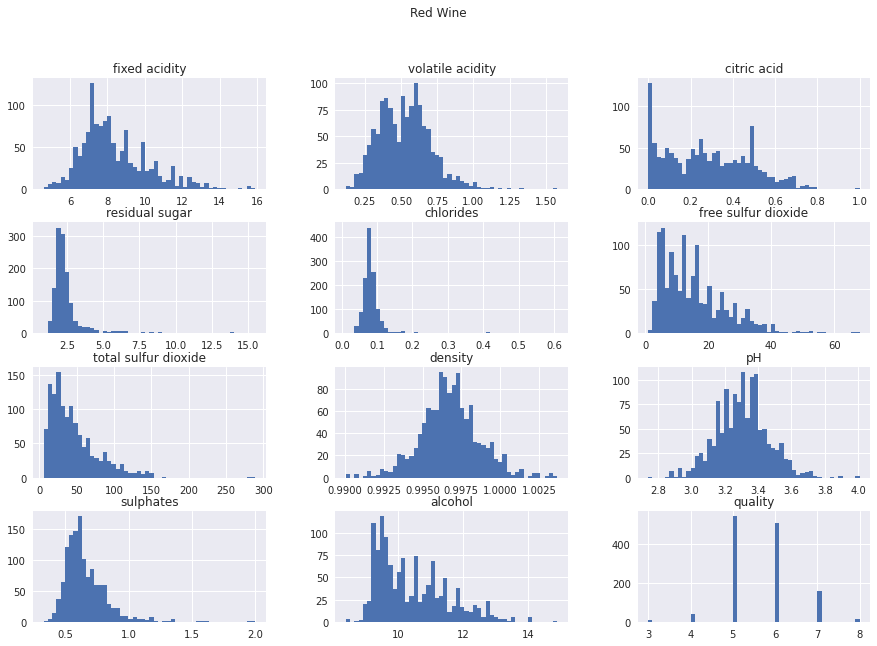

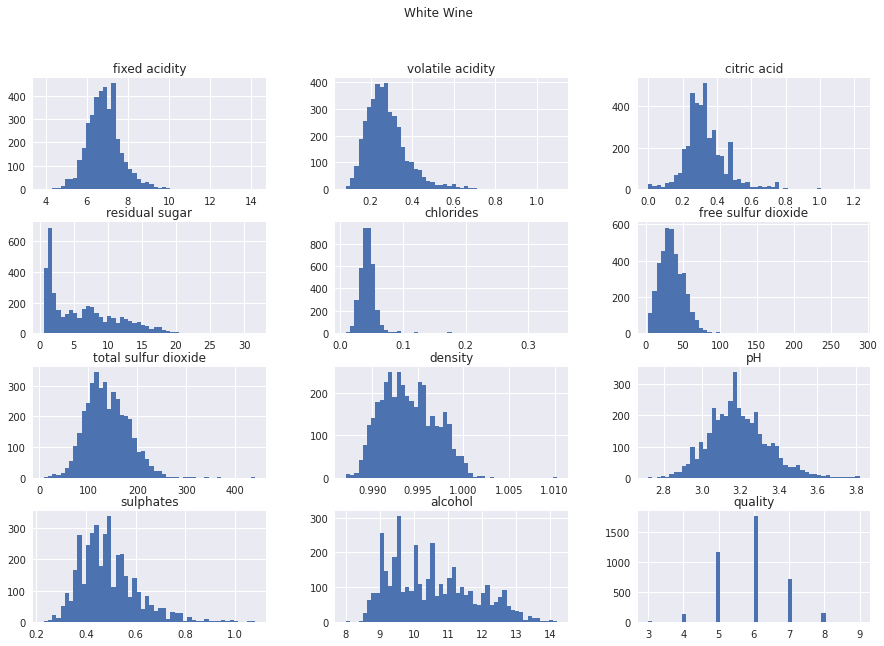

In [70]:
# View a histogram of each feature
for w in rw, ww:
    # Set plot style
    with plt.style.context('seaborn'):
        # Construct histogram with 50 bins for each feature
        hist = w.hist(bins=50, figsize=(15, 10))
        # Title for each set of histograms
        plt.gcf().suptitle(w.name)
    plt.show()

***

### View distribution of target variable
The target variable in this dataset is `quality`. As is obvious from the histograms above, the distribution of the output variable heavily favours the central categories. The red wine dataset is sorted into six ordinal categories from 3 to 8. Categories `5` and `6` represent over 80% of the data. The lowest category, `3`, occurs in only 8 instances, representing 0.6% of the dataset; `4` occurs 42 times  - 1.1% of total ratings. At the upper end of the scale `7` occurs 159 times or ~12% and just 15 red wines, ~1%, hold the higest rating of `8`. 

The white wine dataset shows a similar imbalance. Of its 7 rating categories, 3 to 8, over 90 % fall into the medium group, `5`, `6`, and `7`. Categories `3` and `4` account for a combined 4% of instances, with just 16 wines with a rating of `3`. Similarly, `8` and `9` occur in less than 4% of samples; `9` only occurring 4 times.



In [72]:
# Count occurences of each quality class and calculate percents of total
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    # Count occurrences of each category
    wc = w.quality.value_counts()
    # Calculate percent of total number of samples
    wp = round(w.quality.value_counts() / len(w) * 100, 2)
    # Place in dataframe for ease of presentation and display
    df = pd.concat((wc,wp), axis=1)
    df.columns = ('Count', 'Percent')
    print(df)

-----------
Red Wine
-----------
   Count  Percent
5    545    42.61
6    510    39.87
7    159    12.43
4     42     3.28
8     15     1.17
3      8     0.63
-----------
White Wine
-----------
   Count  Percent
6   1758    44.87
5   1166    29.76
7    704    17.97
8    140     3.57
4    130     3.32
3     16     0.41
9      4     0.10


***

### View feature correlations

For each of the wine datasets (red and white), a correlation matrix is calculated using *pandas* `DataFrame.corr()` function. The correlation coefficient is calcualted between each pair of numeric variables using Pearson's r. The resulting matrices are displayed as heatmaps using `seaborn.heatmap()`. The colourmap used is set to saturate at a correlation coefficient of 0.5 so that high correlations are very obvious. For the same reason the diagonal of the correlation matrix, which always holds a 1.0 as it is the value of a feature's correlation with itself, is removed.

The correlation heatmaps reveal the following:

- In the red wine dataset:
    - `Fixed acidity` is strongly correlated with each of `citric acid`, `density`, and `pH`
    - `Volatile acidity` is strongly correlated with `citric acid`
    - `Citric acid`, in addtion to it's correlations with `fixed acidity` and `volatile acidity`, also displays a fairly strong correlation with `pH`
    - `Total sulfur dioxide` and `free sulfur dioxide` are highly correlated
    - `Density` has a correlation of 0.49 with `alcohol`
    
- In the white wine dataset:
    - `Fixed acidity` is correlated with `pH`
    - `residual sugar` is highly correlated with `density` and, to a lesser extent, `alcohol`
    - `Total sulfur dioxide` and `free sulfur dioxide` are highly correlated
    - `Total sulfur dioxide` is also correlated with `density` and, more weakly with `alcohol`
    - `density`, in addition to its correlation with `residual sugar` and `total sulfur dioxide`, is highly correlated with `alcohol`

Finally, correlation with `quality` shows which attributes have the strongest influence on the output variable. These relationships are discussed below.

-----------
Red Wine
-----------


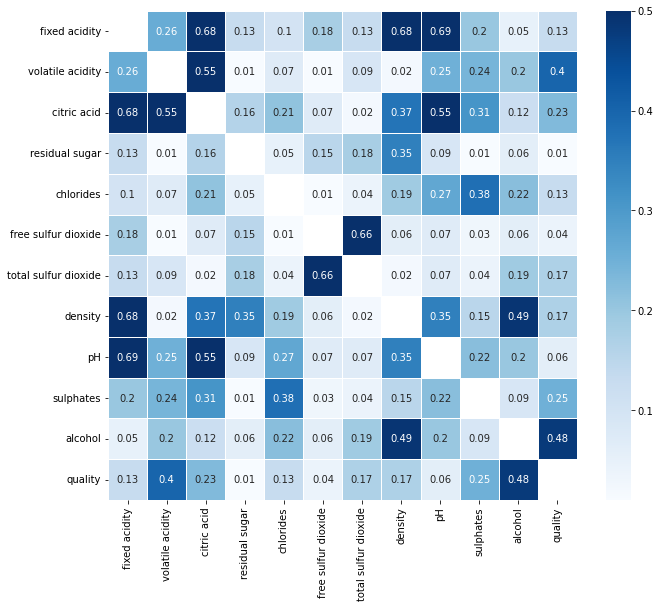

-----------
White Wine
-----------


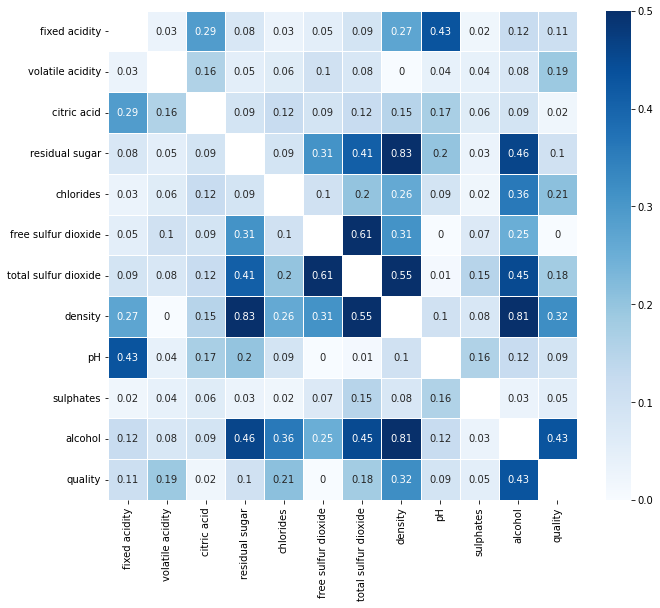

In [74]:
# Set figure size within context so it doesn't affect size of subsequent figures
with plt.rc_context({'figure.figsize':(10.5,9)}):
    # For each or red win and white wine dataframes
    for w in rw, ww:
        # Print the dataframe name
        print(f"-----------\n{w.name}\n-----------")
        # Calculate correlation matrix (using Pearson's r)
        corr = w.corr()
        # Remove distracting self correlations (always = 1)
        np.fill_diagonal(corr.values, 'NaN')
        # Display matrix as heatmap, saturate at 0.5 to make high correlations stand out
        sns.heatmap(abs(corr.round(2)), annot=True, linewidths=0.5, cmap='Blues', vmax=0.5)
        plt.show()

***

### Assess relative influence of each feature on the target variable

The tables below are the the `quality` columns from the correlation matrix calculated earlier, ordered (descending) by correlation coefficient. 

The features which influence red wine `quality` are dominated by `alcohol` and `volatile acidity`, with `sulphates`, `citric acid`, `total sulfur dioxide`, `density`, `chlorides`, and `fixed acidity` having moderate to low influences. `pH`, `free sulfur dioxide`, and `residual sugar` all have a very low correlation with wine quality. White wine `quality` is most influenced by `alcohol` and `density`. `Chlorides`, `volatile acidity`, `total sulfur dioxide`, and `fixed acidity` all exhibit a moderate influence, while `pH`, `residual sugar`, and `sulphates` show low correlation. The influences of `citric acid` and `free sulfur dioxide` are extremely low.

In [75]:
# Sort values in the correlation matrix by the absolute correlation with the target variable
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    # print the sorted absolute values of the correlation between each feature and quality
    print(abs(w.corr()['quality']).drop('quality').sort_values(ascending=False))

-----------
Red Wine
-----------
alcohol                 0.479975
volatile acidity        0.399277
sulphates               0.249611
citric acid             0.234846
density                 0.174829
total sulfur dioxide    0.169174
chlorides               0.129213
fixed acidity           0.128801
pH                      0.060826
free sulfur dioxide     0.042084
residual sugar          0.009056
Name: quality, dtype: float64
-----------
White Wine
-----------
alcohol                 0.431137
density                 0.318386
chlorides               0.210282
volatile acidity        0.189554
total sulfur dioxide    0.179082
fixed acidity           0.113350
residual sugar          0.101933
pH                      0.091669
sulphates               0.047959
citric acid             0.015755
free sulfur dioxide     0.002059
Name: quality, dtype: float64


***

## Feature scaling
[8]
Standardisation is the process of scaling data so that it has a mean of zero and unit variance. Assumed by PCA and rbf kernel and LDA [11] [12]

In [95]:
scaler_rw = StandardScaler()
X_std_rw = scaler_rw.fit_transform(X_train_rw)
scaler_ww = StandardScaler()
X_std_ww = scaler_ww.fit_transform(X_train_ww)

***

## Dimensionality reduction

### Feature selection

1. Drop any features with an absolute correlation of less than 0.1
1. Drop features that are highly correlated

In [178]:
# Custom Transformer for dropping features based on correlation with output variable
class DropLessImportantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.1):
        self.threshold=threshold
    def fit(self, X, y):
        return self
    def transform(self, X, y):
        # Calculate correlation coefficients, only keep the last one
        # because we only want each feature's correlation with y
        drop = abs(np.corrcoef(X, y, rowvar=False)[:,-1]) < self.threshold
        # Remove columns (features) where correlation coefficient with
        # y (output variable) is lower than threshold
        return np.delete(X_std_rw, drop[0:-1], axis=1)

In [182]:
drop_unimportant = DropLessImportantFeatures()
x_std_dropped = drop_unimportant.transform(X_std_ww, y_train_ww)

In [183]:
x_std_dropped.shape

(1279, 7)

In [175]:
drop = abs(np.corrcoef(X_std_rw, y_train_rw, rowvar=False)[:,-1]) < 0.1
pruned = np.delete(X_std_rw, drop[0:-1], axis=1)

array([ 0.12880076, -0.39927723,  0.23484565, -0.1292133 , -0.16917416,
       -0.17482933,  0.24961086,  0.47997532,  1.        ])

### Principal components analysis (PCA)

In [84]:
# [7] PCA
pca_rw = PCA(n_components=0.99)
pca_ww = PCA(n_components=0.99)
X_pca_rw = pca_rw.fit_transform(X_std_rw)
X_pca_ww = pca_ww.fit_transform(X_std_ww)

### Kernel PCA

In [115]:
# [8] Kernel PCA
kpca_rw = KernelPCA(n_components=3, kernel="rbf", gamma=0.04)
X_kpca_rw = kpca_rw.fit_transform(X_std_rw)
kpca_ww = KernelPCA(n_components=3, kernel="rbf", gamma=0.04)
X_kpca_ww = kpca_ww.fit_transform(X_std_ww)

### Linear Discriminant Analysis (LDA)

### Feature Agglomeration

In [ ]:
# [10] 

In [86]:
pca_rw.components_

array([[-7.34808368e-03,  4.47150293e-04,  8.88055731e-05,
         7.54334206e-03,  5.79108819e-05,  2.10386087e-01,
         9.77543417e-01,  1.12536075e-06, -2.74852826e-04,
         1.98611108e-04, -5.94476843e-03],
       [-2.86005424e-02, -1.73558006e-03, -3.15371284e-03,
         7.76679749e-03, -1.72177674e-04,  9.77038222e-01,
        -2.10464869e-01, -2.91110351e-05,  3.52530471e-03,
         2.13605972e-04,  1.40383575e-02]])

In [ ]:
X, y = train.drop(['quality_cat'], axis=1), train['quality_cat']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(test.drop(['quality_cat'], axis=1)) 
model = SVC(kernel="poly", degree=3, coef0=1, C=5)
# svm_clf = Pipeline([
#     ("scaler", StandardScaler()),
#     ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5)),
# ])

model.fit(X_scaled,y)

In [ ]:
model.score(X_test_scaled, test['quality_cat'])

### Cross validation

In [ ]:
scores = cross_val_score(model, X_scaled, y, cv=10)
print(scores, '\n', scores.mean(), '\n', scores.std())

### Stratified shuffle split

In [ ]:
rwdd =rwd.drop(['quality'], axis=1)

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
X, y = rwdd.drop(['quality_cat'], axis=1), rwdd['quality_cat']
for train_idx, test_idx in sss.split(rwdd.drop(['quality_cat'], axis=1), rwdd['quality_cat']):
    X_train, X_test = X.loc[train_idx], X.loc[test_idx] 
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]


In [ ]:
# svm_clf = Pipeline([
#     ("scaler", StandardScaler()),
#     ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5)),
# ])
svm_clf = make_pipeline(StandardScaler(), SVC(kernel="poly", degree=3, coef0=1, C=5))
svm_clf.fit(X_train, y_train)

In [ ]:
svm_clf.score(X_test, y_test)

In [ ]:
scores = cross_val_score(svm_clf, X, y, cv=10)
print(scores, '\n', scores.mean(), '\n', scores.std())

In [ ]:
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv=5)

In [ ]:
cm = confusion_matrix(y_train, y_train_pred, labels=['low', 'medium', 'high'])

In [ ]:
plt.figure(figsize=(3,2))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, labels=['low', 'medium', 'high'])
plt.grid(False)
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
avg = 'weighted'
for score in (precision_score, recall_score, f1_score):
    print(f"{score.__name__}: {score(y_train, y_train_pred, average=avg)}")
          
          
precision = precision_score(y_train, y_train_pred, average=avg)
recall = recall_score(y_train, y_train_pred, average=avg)
f1 = f1_score(y_train, y_train_pred, average=avg)
print(precision, recall, f1)

### All medium classifier

In [ ]:
class alwaysMedium(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return(['medium'] * len(X))

In [ ]:
model = alwaysMedium()
scores = cross_val_score(model, X, y, cv=10, scoring="accuracy")
print(scores, '\n', scores.mean(), '\n', scores.std())

***
***

## References

[1] Cortez, P., Cerdeira, A., Almeida, F., Matos, T., Reis, J., 2009, Modeling wine preferences by data mining from physicochemical properties, Decision Support Systems 47(4):547-553. doi:10.1016/j.dss.2009.05.016 

[2] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science

[3] Scikit-learn developers, https://scikit-learn.org/stable/modules/preprocessing.html

[4] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol

[5] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split

[6] Should we apply normalization to test data as well? https://datascience.stackexchange.com/a/27616

[7] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol p:223

[8] https://stats.stackexchange.com/a/69159 Why do we need to normalize data before principal component analysis (PCA)?

[9] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol p:227

[10] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol p:233  #### LDA good to reduce dimensionality before another classifcation algorithm such as SVM

[11] https://scikit-learn.org/stable/modules/preprocessing.html Standardization, or mean removal and variance scaling

[12] https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html sklearn.discriminant_analysis.LinearDiscriminantAnalysis "The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix."